## CREATE AND CUT THE GRAPH

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install leidenalg==0.7.0

In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time

## Import files

In [4]:
# LARGE
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v3.pt" 

mask_file_hard = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_HARD_EDGES.pt"
mask_file_dot = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_DOT_PRODUCT.pt"
mask_file_l1norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L1_NORM.pt"
mask_file_l2norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L2_NORM.pt"

## Helper function

In [5]:
def all_together_hdbscan(g):
    partition = g.find_partition_hdbscan()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [6]:
def all_together_watershed(g):
    partition = g.find_partition_watershed()
    g.plot_partition(partition, size_threshold=10, figsize=(12,12), density=False, bins=10)

In [7]:
def all_together_leiden(g, resolution):
    partition = g.find_partition_leiden(resolution=resolution).filter_by_size(min_size=10)
    concordance = partition.concordance_with_partition(other_partition=g.initial_partition)
    
    
    g.plot_partition(partition, min_size=0, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])

## Load and plot

In [157]:
tiling = torch.load(mask_file_dot, map_location=torch.device('cpu'))
tiling = tiling.reduce_similarity_radius(new_radius = 2)

g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

In [158]:
g.graph.summary()

'IGRAPH U-W- 3035 31107 -- \n+ attr: total_edge_weight (g), total_nodes (g), d (v), label (v), size (v), weight (e)'

In [159]:
g.graph.attributes()

['total_edge_weight', 'total_nodes']

In [160]:
g.graph["total_nodes"]

3035

In [161]:
g.graph["total_edge_weight"]

24436.031015530494

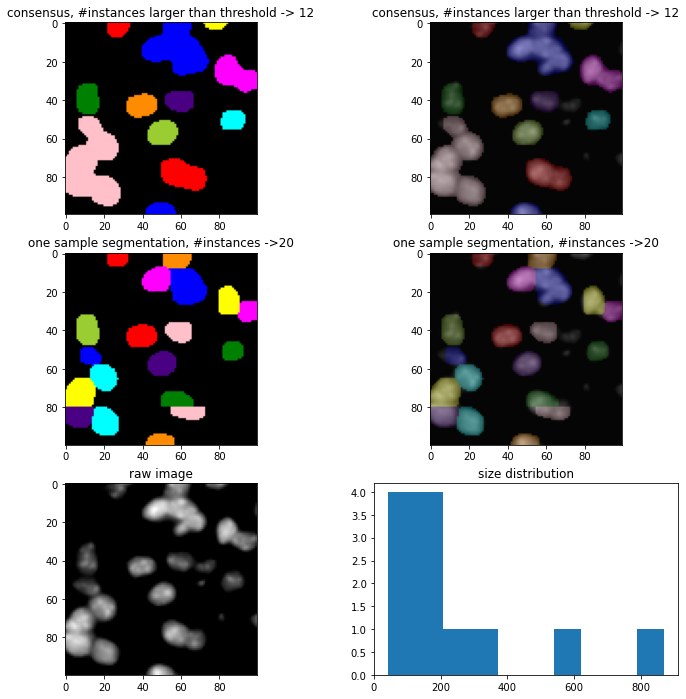

In [162]:
_ = g.plot_cc()

0.8172847032546997 2 0.8172847032546997 0.7659048438072205


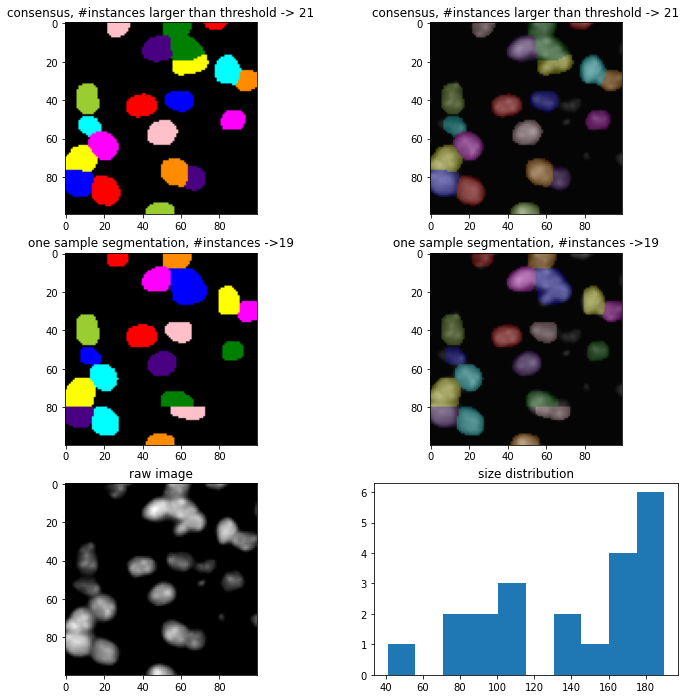

In [179]:
partition = g.find_partition_leiden(resolution=3.0).filter_by_size(min_size=10)
seg_mask = g.partition_2_mask(partition)
concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
print(concordance.mean_IoU, concordance.delta_n, concordance.mean_IoU, concordance.mean_IoU_reverse)
_ = g.plot_partition(partition, size_threshold=0, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])

In [237]:
video_list, title_list = [], []
for r in numpy.arange(0.1,1.0,0.2):
    partition = g.find_partition_leiden(resolution=r).filter_by_size(min_size=10)
    seg_mask = g.partition_2_mask(partition)
    video_list.append(seg_mask)
    title_list.append('res={0:.3f} n={1:2d}'.format(r,len(partition.sizes)-1))
video = torch.stack(video_list, dim=0).cpu().numpy()



print(title_list)

['res=0.100 n=13', 'res=0.300 n=16', 'res=0.500 n=18', 'res=0.700 n=19', 'res=0.900 n=20']


In [243]:
import matplotlib.pylab as plt
from matplotlib import animation
from IPython.display import HTML
from typing import List, Tuple

def show_video(
        title: List[str],
        ref_image: numpy.ndarray,
        video: numpy.ndarray,
        figsize: Tuple[int, int] = (8, 4),
        interval: int = 50):
    """
    :param video: an ndarray with shape (n_frames, height, width)
    :param title: an list of lenght (n_frames)    
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ax_video = axs[0]
    ax_image = axs[1]
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(video[0, ...], bg_label=0), aspect='equal')
    # intensity histogram
    _ = ax_image.imshow(ref_image, cmap='gray', aspect='equal')
    ax_video.set_title("resolution="+str(0))
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(video[0, ...])
        ax_video.set_title("resolution="+str(0))
        
    def animate(i):
        ax_video.imshow(skimage.color.label2rgb(video[i, ...], bg_label=0), aspect='equal')
        ax_video.set_title(title[i])

        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

In [241]:
show_video(title=title_list, video=video, ref_image=g.raw_image[0].cpu().numpy(), interval=1000)

In [116]:
RBER = dict()
for n,r in enumerate(numpy.arange(0.1,10.0,0.2)):
    partition = g.find_partition_leiden(resolution=r).filter_by_size(min_size=10)
    partit
    concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
    RBER[n] = (r, partition, concordance)
    
RB = dict()
for n,r in enumerate(numpy.arange(0.1,10.0,0.2)):
    partition = g.find_partition_leiden(resolution=r).filter_by_size(min_size=10)
    concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
    RBER[n] = (r, partition, concordance)

In [117]:
n = [n for n in RBER.keys()]
r = [res for res,partition,concordance in RBER.values()]
delta_n = [concordance.delta_n for res,partition,concordance in RBER.values()]
iou = [concordance.mean_IoU for res,partition,concordance in RBER.values()]
iou_r = [concordance.mean_IoU_reverse for res,partition,concordance in RBER.values()]

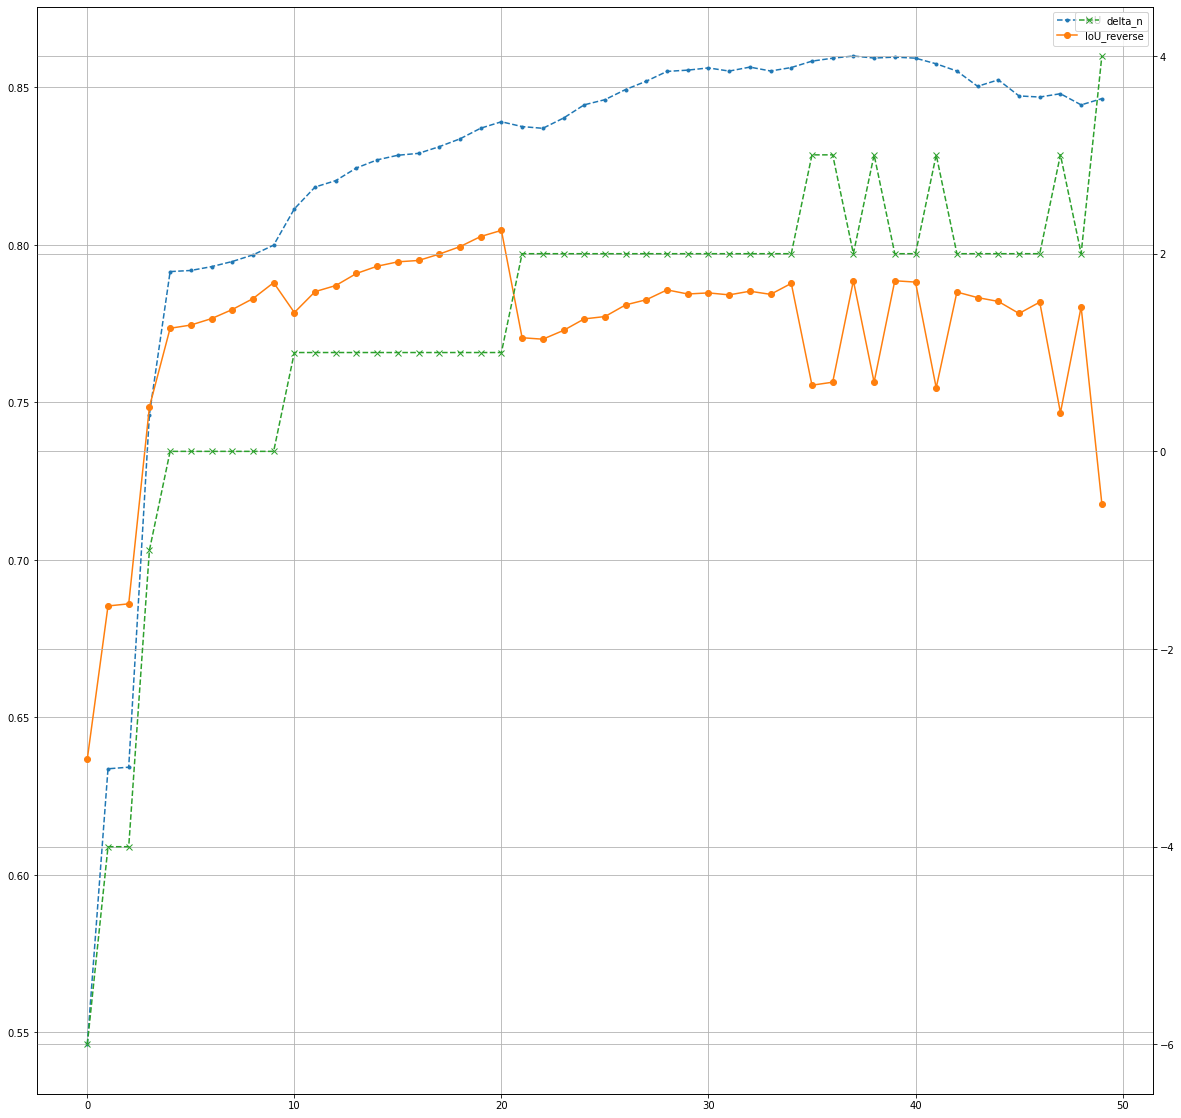

In [118]:
fontsize=20
labelsize=20
figure, ax1a = plt.subplots(figsize=(20,20))

color = 'tab:red'
ax1a.plot(n, iou, '.--', label="IoU")
ax1a.plot(n, iou_r, 'o-', label="IoU_reverse")
plt.legend()
ax1a.grid()

ax1b = ax1a.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
plt.plot(n,delta_n,'x--',label="delta_n",color=color)
ax1b.grid()
plt.legend()

In [123]:
p = RBER[21][1]
print(p)

Partition(type='leiden', membership=tensor([18, 18, 18,  ..., 19, 19,  0]), sizes=tensor([138, 292, 191, 185, 185, 181, 181, 171, 168, 167, 165, 159, 137, 112,
        102,  99,  99,  93,  79,  78,  39,  16]), params={'resolution': 4.300000000000001, 'filter_by_size': 10})


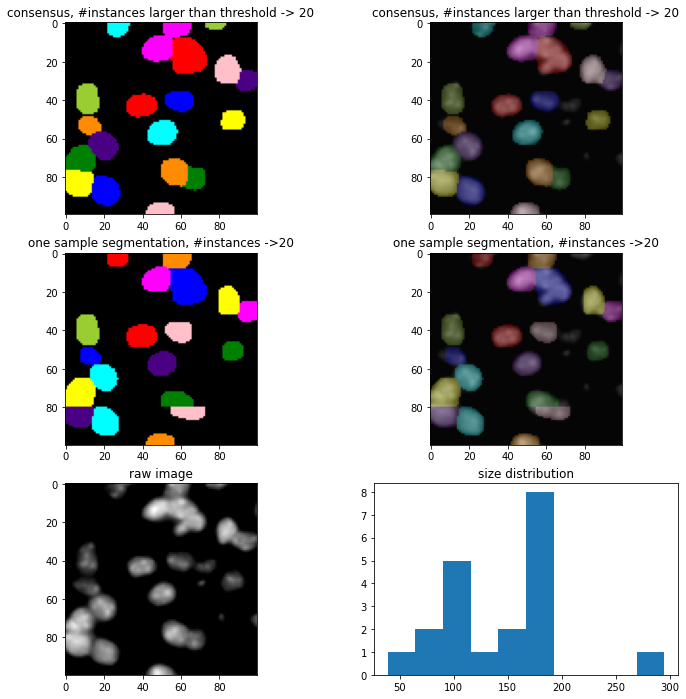

In [125]:
_ = g.plot_partition(RBER[20][1])

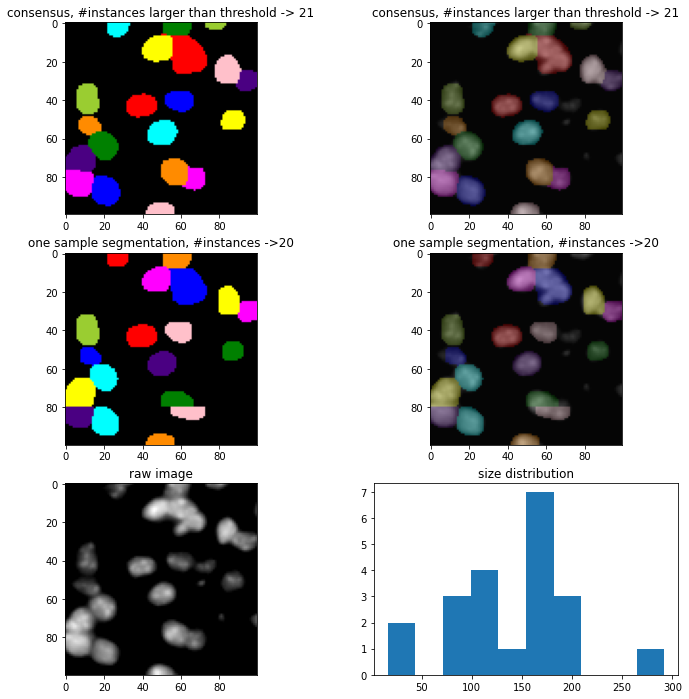

In [126]:
_ = g.plot_partition(RBER[21][1])